##  Importation des données dans InfluxDB

In [1]:
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## InfluxDB

In [4]:
from influxdb import DataFrameClient

In [5]:
# see https://influxdb-python.readthedocs.io/en/latest/examples.html#tutorials-pandas
"""Instantiate the connection to the InfluxDB client."""

host, port = 'localhost', 8086
user, password = 'root', 'root'
dbname = 'weatherdata'
protocol = 'line'

CLIENT = DataFrameClient(host, port, user, password, dbname)

print("Create database: " + dbname)
CLIENT.create_database(dbname)

Create database: weatherdata


In [6]:
# /!\ delete /!\
# CLIENT.drop_database( dbname  )

In [7]:
coords = (45.1973288, 5.7139923)

In [8]:
firstday = '2017-10-11'
lastday = '2017-11-08'

daterange = pd.date_range(start=firstday, end=lastday,  freq='D', normalize=True)
daterange_iso = daterange.strftime('%Y-%m-%dT%H:%M:%SZ')

## Darksky

In [6]:
from darksky import forecast

# """ You get 1,000 API calls for free each day. """

# Load the API key for darksky
with open('darksky_key.txt') as f:
    KEY = f.read()

EXCLUDE = ['currently', 'minutely', 'daily', 'flags']  # from the query

In [7]:
def query2dataframe( coords,  day ):
    # query
    data = forecast(KEY, *coords, units='si', lang='fr', time=day, exclude=EXCLUDE)
    
    print('get data for %s' % day)
    
    # build the DataFrame from records (dict)
    records = data['hourly']['data']  
    weatherdataDF = pd.DataFrame.from_records(records, index='time')

    weatherdataDF.index = pd.to_datetime(weatherdataDF.index, unit='s')
    
    # debug: force les valeurs en flottant  ( plutôt que Int à cause des NaN ) 
    cols_int = list( weatherdataDF.select_dtypes(include=['int']).columns )
    for c in cols_int:
        weatherdataDF[c] = weatherdataDF[c].dropna().astype(float)
        
    return weatherdataDF

In [8]:
def dataFrame2influx( measurement_name, DF ):
    # Ajoute colone par colones pour retirer les NaN...
    for c in DF.columns:
        CLIENT.write_points(DF[[c]].dropna(), measurement_name)
        
def add1day( measurement_name, coords, day ):
    weatherdataDF = query2dataframe( coords,  day )
    dataFrame2influx( measurement_name, weatherdataDF )

In [9]:
measurement_name = 'darksky'

In [10]:
for d in daterange_iso:
    add1day( measurement_name, coords, d )

get data for 2017-10-11T00:00:00Z
get data for 2017-10-12T00:00:00Z
get data for 2017-10-13T00:00:00Z
get data for 2017-10-14T00:00:00Z
get data for 2017-10-15T00:00:00Z
get data for 2017-10-16T00:00:00Z
get data for 2017-10-17T00:00:00Z
get data for 2017-10-18T00:00:00Z
get data for 2017-10-19T00:00:00Z
get data for 2017-10-20T00:00:00Z
get data for 2017-10-21T00:00:00Z
get data for 2017-10-22T00:00:00Z
get data for 2017-10-23T00:00:00Z
get data for 2017-10-24T00:00:00Z
get data for 2017-10-25T00:00:00Z
get data for 2017-10-26T00:00:00Z
get data for 2017-10-27T00:00:00Z
get data for 2017-10-28T00:00:00Z
get data for 2017-10-29T00:00:00Z
get data for 2017-10-30T00:00:00Z
get data for 2017-10-31T00:00:00Z
get data for 2017-11-01T00:00:00Z
get data for 2017-11-02T00:00:00Z
get data for 2017-11-03T00:00:00Z
get data for 2017-11-04T00:00:00Z
get data for 2017-11-05T00:00:00Z
get data for 2017-11-06T00:00:00Z
get data for 2017-11-07T00:00:00Z
get data for 2017-11-08T00:00:00Z


### debug

In [370]:
weatherdataDF = query2dataframe( coords,  '2017-09-02T00:00:00Z' )

get data for 2017-09-02T00:00:00Z


## EmonCMS

In [3]:
import emoncmsfeed as getfeeds

In [4]:
dataframefreq = '15min'
feeds =  { 'T_int': 3 }

In [5]:
measurement_name = 'openenergymonitor'

In [25]:
for i in range( len( daterange_iso )-1 ):
    startday = pd.to_datetime(daterange_iso[i], format='%Y-%m-%dT%H:%M:%SZ')
    lastday = pd.to_datetime(daterange_iso[i+1], format='%Y-%m-%dT%H:%M:%SZ')
    
    data = getfeeds.builddataframe( feeds, dataframefreq , startdate=startday, enddate=lastday )
    
    # cas jour sans donnée
    if len( data ) == 0 :
        print('no data %s'%daterange_iso[i])
        continue
    
    # Ajoute colone par colones pour retirer les NaN...
    for c in data.columns:
        CLIENT.write_points(data[[c]].dropna(), measurement_name)

no data 2017-10-18T00:00:00Z
no data 2017-10-19T00:00:00Z
no data 2017-10-20T00:00:00Z


In [42]:
startday = pd.to_datetime('2017-11-05T12:00:00Z', format='%Y-%m-%dT%H:%M:%SZ')
lastday = pd.to_datetime('2017-11-06T00:00:00Z', format='%Y-%m-%dT%H:%M:%SZ')

data = getfeeds.builddataframe( feeds, dataframefreq , startdate=startday, enddate=lastday )

In [43]:
data

,T_int
2017-11-05 11:00:00+00:00,16.222223
2017-11-05 11:15:00+00:00,16.200001
2017-11-05 11:30:00+00:00,16.200001
2017-11-05 11:45:00+00:00,16.200001
2017-11-05 12:00:00+00:00,16.192858
2017-11-05 12:15:00+00:00,16.183334
2017-11-05 12:30:00+00:00,16.200001
2017-11-05 12:45:00+00:00,16.200001
2017-11-05 13:00:00+00:00,16.200001
2017-11-05 13:15:00+00:00,16.200001


In [37]:
startday.timestamp()

1509883200.0

In [38]:
print( startday.tzname() )

UTC


In [39]:
int( startday.timestamp( unit='ms' ) )

TypeError: timestamp() takes no keyword arguments

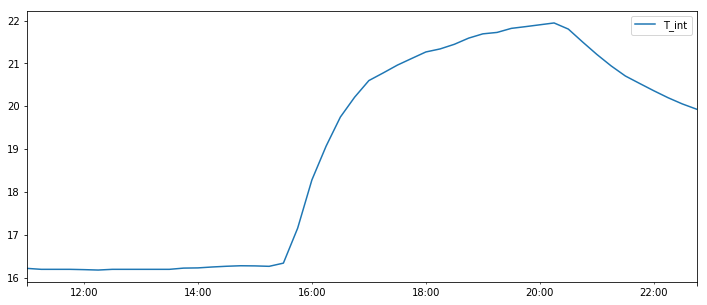

In [44]:
data.plot(figsize=(12, 5))

# Irradiation solaire

In [26]:
import sunradiation as sun

In [27]:
query = 'SELECT cloudCover FROM darksky'

In [28]:
cloudcover = CLIENT.query(query)
cloudcoverDF = cloudcover['darksky']

In [29]:
cloudcoverDF = cloudcoverDF.resample('15min').interpolate()

In [30]:
sundata = sun.buildmultidayDF( coords, cloudcoverDF.index, cloudCover = cloudcoverDF['cloudCover']  )

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


In [31]:
measurement_name = 'sundata'

# Ajoute colone par colones pour retirer les NaN...
for c in sundata.columns:
    CLIENT.write_points(sundata[[c]].dropna(), measurement_name)

### Projection sur les surfaces vitrées

In [32]:
# surface (m2),  sigma (deg),  azimuth (deg)
windows = { 'bastille':(1.2*0.8,    37, 50) ,
            'cuisine':(0.3*0.72 *2, 90, 50 ),
            'chambre':(0.3*0.72 *2, 90, 180+50),
            'vercors':(0.6*0.8 * 2, 37, 180+50) }

In [33]:
sunFlux_dict = {}

for k, values in windows.items():
    sunFlux_dict['flux_'+k] = values[0] * sun.projectDF( values[1], values[2], sundata )

sunFlux_DF = pd.DataFrame( sunFlux_dict )

# Somme
sunFlux_DF['flux_tot'] = sunFlux_DF.sum(axis=1)

In [34]:
sunFlux_DF

,flux_bastille,flux_chambre,flux_cuisine,flux_vercors,flux_tot
2017-06-20 04:00:00+00:00,0.000000,0.0,0.000000,0.000000,0.000000
2017-06-20 04:15:00+00:00,0.000000,0.0,0.000000,0.000000,0.000000
2017-06-20 04:30:00+00:00,0.000000,0.0,0.000000,0.000000,0.000000
2017-06-20 04:45:00+00:00,0.000000,0.0,0.000000,0.000000,0.000000
2017-06-20 05:00:00+00:00,0.000000,0.0,0.000000,0.000000,0.000000
2017-06-20 05:15:00+00:00,0.000000,0.0,0.000000,0.000000,0.000000
2017-06-20 05:30:00+00:00,237.149653,0.0,105.673584,0.000000,342.823236
2017-06-20 05:45:00+00:00,291.745678,0.0,124.817429,0.000000,416.563107
2017-06-20 06:00:00+00:00,345.235859,0.0,142.234971,0.000000,487.470830
2017-06-20 06:15:00+00:00,397.093150,0.0,157.878868,0.000000,554.972018


In [35]:
measurement_name = 'sundata'

# Ajoute colone par colones pour retirer les NaN...
for c in sunFlux_DF.columns:
    CLIENT.write_points(sunFlux_DF[[c]].dropna(), measurement_name)

In [51]:
sunFlux_DF.index

DatetimeIndex(['2017-06-20 04:00:00+00:00', '2017-06-20 04:15:00+00:00',
               '2017-06-20 04:30:00+00:00', '2017-06-20 04:45:00+00:00',
               '2017-06-20 05:00:00+00:00', '2017-06-20 05:15:00+00:00',
               '2017-06-20 05:30:00+00:00', '2017-06-20 05:45:00+00:00',
               '2017-06-20 06:00:00+00:00', '2017-06-20 06:15:00+00:00',
               ...
               '2017-10-11 14:45:00+00:00', '2017-10-11 15:00:00+00:00',
               '2017-10-11 15:15:00+00:00', '2017-10-11 15:30:00+00:00',
               '2017-10-11 15:45:00+00:00', '2017-10-11 16:00:00+00:00',
               '2017-10-11 16:15:00+00:00', '2017-10-11 16:30:00+00:00',
               '2017-10-11 16:45:00+00:00', '2017-10-11 17:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=10901, freq='15T')